In [43]:
Z_DIM = 10

### 1. Load dataset

In [44]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
from PIL import Image, ImageColor
from pathlib import Path

import torch
import torch.nn.functional as F
import torch.nn as nn

from torch import tensor
from torchvision import transforms
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torch.distributions.constraints as constraints
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(palette='Set2')
import time

import pandas as pd
from tqdm import tqdm
import os
import math

from IPython.display import clear_output

from google.colab import drive
drive.mount('/content/drive')

import itertools

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
# !unzip -q /content/drive/MyDrive/thesis/pendulum/pendulum.zip -d .

In [46]:
class Synthetic(Dataset):
    def __init__(self, root, dataset="train"):
        root = root + "/" + dataset

        imgs = os.listdir(root)
        imgs = [i for i in imgs if i != '.DS_Store']

        self.dataset = dataset
        self.imgs = [os.path.join(root, k) for k in imgs]
        self.imglabel = [list(map(int, k[:-4].split("_")[1:])) for k in imgs]
        self.transforms = transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize((0.5, 0.5, 0.5, 0), (0.5, 0.5, 0.5, 1))])
    def __getitem__(self, idx):
        img_path = self.imgs[idx]

        label = torch.from_numpy(np.asarray(self.imglabel[idx]))
        pil_img = Image.open(img_path)
        label = torch.from_numpy(np.asarray(label))
        data = self.transforms(pil_img)[:3]
        ret = {
            'img': data,
            'label': label,
        }
        return ret

    def __len__(self):
        return len(self.imgs)

In [47]:
dataset_dir = 'pendulum'
Tr_dataset = Synthetic(dataset_dir, "train")
TrCF_dataset = Synthetic(dataset_dir, "test")
CF_dataset = Synthetic(dataset_dir, "cf")
Tr_dataset[0]['img'].shape

torch.Size([3, 96, 96])

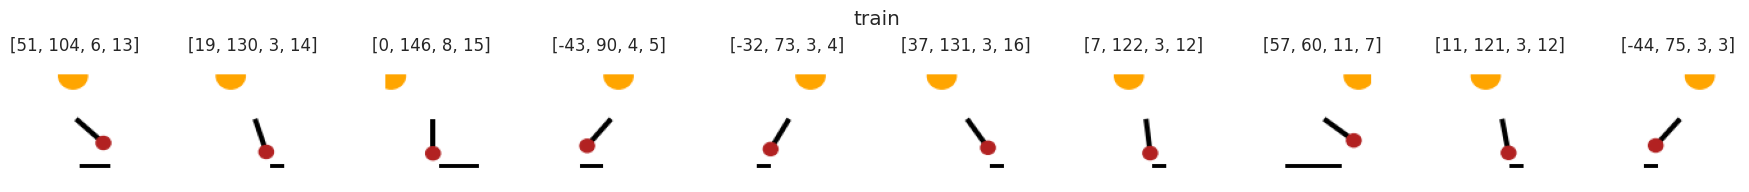

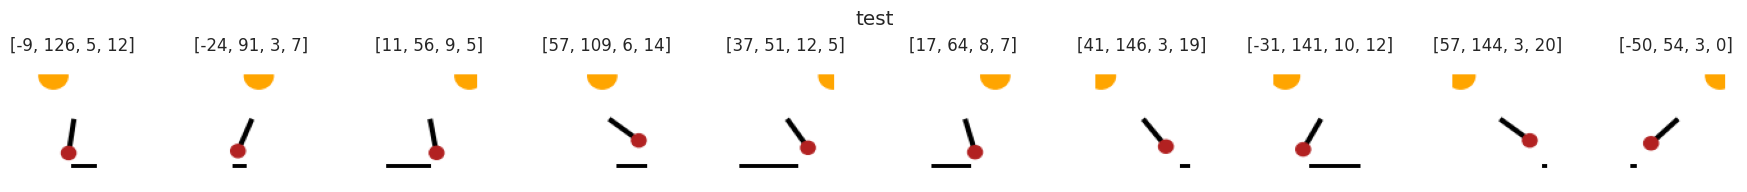

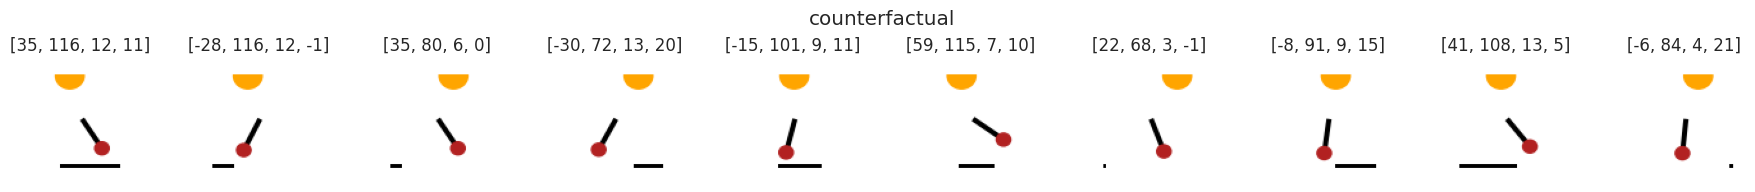

In [48]:
def normalize(img):
    a = np.expand_dims([0.5, 0.5, 0.5], (0,1))
    normalized = img * a + a
    return normalized.clip(0, 1)

for n, dataset in zip(['train', 'test', 'counterfactual'], [Tr_dataset, TrCF_dataset, CF_dataset]):
    plt.figure(figsize=(18, 2))
    for i in range(10):
        plt.subplot(1, 10, i+1)
        sample = dataset[i]
        plt.imshow(normalize(sample['img'].permute(1, 2, 0)))
        plt.title(str(sample['label'].tolist()))
        plt.axis('off')
    plt.suptitle(n, y=.95)
    plt.tight_layout()

In [49]:
BATCH_SIZE = 64
Tr_loader = DataLoader(Tr_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
TrCF_loader = DataLoader(TrCF_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)
cf_loader = DataLoader(CF_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [50]:
len(Tr_dataset), len(TrCF_dataset), len(CF_dataset)

(10183, 1697, 1697)

### 2. Load Classifier

In [51]:
class PendulumRegressor(nn.Module):
    def __init__(self, dropout_p=0.5):
        super(PendulumRegressor, self).__init__()
        self.p = 0.4
        self.shade_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(192, 64),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(64, 2),
        )
        self.sun_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2304, 512),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(64, 1),
        )
        self.pend_net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1960, 512),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(self.p),
            nn.Linear(64, 1),
        )

    def forward(self, x):
        sun, pend, shade = x[:, 1, :24].unsqueeze(1), x[:, 1, 45:80, 20:-20].unsqueeze(1), x[:, 1, 83:85]
        sun_pred = self.sun_net(sun)
        pend_pred = self.pend_net(pend)
        shade_pred = self.shade_net(shade)
        return torch.cat([pend_pred, sun_pred, shade_pred], dim=1)

In [52]:
device = f"cuda" if torch.cuda.is_available() else "cpu"
regressor = PendulumRegressor().to(device)
regressor.load_state_dict(torch.load('/content/drive/MyDrive/thesis/regressor.pth', map_location=device))

<All keys matched successfully>

In [53]:
regressor.train(False)

PendulumRegressor(
  (shade_net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=192, out_features=64, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
  (sun_net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2304, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=512, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=1, bias=True)
  )
  (pend_net): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1960, out_features=512, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=512, out_features=64, bias=True)
    (5): ReLU()
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=64, out_features=1, bias=True)
  )
)

### 3. CVAE

In [54]:
!pip install -q pyro-ppl
import pyro
import pyro.distributions as dist
import pyro.contrib.examples.util
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam, SGD
from pyro.infer import TraceEnum_ELBO, config_enumerate, infer_discrete

pyro.set_rng_seed(0)
pyro.enable_validation(True)
pyro.distributions.enable_validation(False)

In [55]:
class Encoder(nn.Module):
    def __init__(self, z_dim=Z_DIM, label_dim=4, p=0.1):
        super(Encoder, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, 3),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(32, 64, 3),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 96, 3),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(96, 96, 3),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(),
            nn.Flatten(),
            nn.Dropout(p)
        )
        self.fc_output_loc = nn.Linear(3456 + label_dim, z_dim)
        self.fc_output_scale = nn.Linear(3456 + label_dim, z_dim)

    def forward(self, x, labels):
        hidden = self.conv_layers(x)
        hidden = torch.cat([hidden, labels], dim=1)
        z_loc = self.fc_output_loc(hidden)
        z_scale = torch.exp(self.fc_output_scale(hidden))
        return z_loc, z_scale

class Decoder(nn.Module):
    def __init__(self, z_dim=Z_DIM, p=0.1):
        super(Decoder, self).__init__()
        self.first_layer = nn.Linear(in_features=z_dim, out_features=96*6*6)
        self.upsampling_layers = nn.Sequential(
            nn.BatchNorm2d(96),
            nn.LeakyReLU(),
            nn.Dropout(p),
            nn.Conv2d(96, 96, 3, 1, 1),
            nn.Upsample((12, 12)),
            nn.BatchNorm2d(96),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(96, 64, 3, 1, 1),
            nn.Upsample((24, 24)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.Upsample((48, 48)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(64, 32, 3, 1, 1),
            nn.Upsample((96, 96)),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Dropout2d(p),
            nn.Conv2d(32, 3, 3, 1, 1),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.first_layer(z).view((-1, 96, 6, 6))
        return self.upsampling_layers(x)

In [56]:
MSE_DAMPING_FACTOR = 0.05

def mse(A, B):
    return ((A - B)**2).mean(axis=1)

class CVAE(nn.Module):
    def __init__(self, regressor, z_dim=Z_DIM, label_dim=4, p=0.2, use_cuda=True):
        super().__init__()
        self.encoder_ = Encoder(z_dim, label_dim=label_dim, p=p)
        self.decoder_ = Decoder(z_dim + label_dim, p=p)
        self.regressor_ = regressor
        if use_cuda:
            self.cuda()
        self.use_cuda = use_cuda
        self.z_dim = z_dim
        self.label_dim = label_dim

    def model(self, x, labels, x_TrCF, labels_TrCF):
        if self.use_cuda:
            x = x.cuda()
            x_TrCF = x_TrCF.cuda()
            labels = labels.cuda()
            labels_TrCF = labels_TrCF.cuda()
        pyro.module("decoder", self.decoder_)

        with pyro.plate("data", x.shape[0]):
            # pior for Z
            z_loc = x.new_zeros(torch.Size((x.shape[0], self.z_dim)))
            z_scale = x.new_ones(torch.Size((x.shape[0], self.z_dim)))
            z = pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

            # decode img using z
            loc_img = self.decoder_(torch.cat([z, labels], dim=1))
            pyro.sample("obs", dist.Bernoulli(loc_img.squeeze()).to_event(3),
                        obs=x.squeeze())

            # loss-2
            loc_img_TrCF = self.decoder_(torch.cat([z, labels_TrCF], dim=1))
            real_mse = mse(self.regressor_(loc_img_TrCF), labels_TrCF) * MSE_DAMPING_FACTOR
            pyro.sample("mse", dist.Normal(real_mse, torch.ones(x.shape[0]).to(device)).to_event(1),
                        obs=torch.zeros(x.shape[0]).to(device))

    def guide(self, x, labels, x_TrCF, labels_TrCF):
        if self.use_cuda:
            x = x.cuda()
            x_TrCF = x_TrCF.cuda()
            labels = labels.cuda()
            labels_TrCF = labels_TrCF.cuda()
        pyro.module("encoder", self.encoder_)
        with pyro.plate("data", x.shape[0]):
            z_loc, z_scale = self.encoder_(x, labels)
            pyro.sample("latent", dist.Normal(z_loc, z_scale).to_event(1))

    def encoder(self, x, labels, return_cpu=True):
        if self.use_cuda:
            x = x.cuda()
            labels = labels.cuda()
        z_loc, z_scale = self.encoder_(x, labels)
        if self.use_cuda and return_cpu:
            z_loc = z_loc.cpu()
            z_scale = z_scale.cpu()
        return z_loc, z_scale

    def decoder(self, z, labels, return_cpu=True):
        if self.use_cuda:
            z = z.cuda()
            labels = labels.cuda()
        loc_img = self.decoder_(torch.cat([z, labels], dim=1))
        if self.use_cuda and return_cpu:
            loc_img = loc_img.cpu()
        return loc_img

    @torch.inference_mode()
    def reconstruct_img(self, x, labels, return_cpu=True):
        z_loc, z_scale = self.encoder(x, labels)
        z = dist.Normal(z_loc, z_scale).sample()
        loc_img = self.decoder(z, labels)
        return loc_img

### 4. Train

In [57]:
def run_epoch(svi, Tr_loader, TrCF_loader):
    epoch_loss = 0.
    for Tr_batch, TrCF_batch in zip(Tr_loader, itertools.cycle(TrCF_loader)):
        if len(TrCF_batch) != len(Tr_batch):
            k = min(len(TrCF_batch), len(Tr_batch))
            epoch_loss += svi.step(Tr_batch['img'][:k].to(device), Tr_batch['label'][:k].to(device),
                                   TrCF_batch['img'][:k].to(device), TrCF_batch['label'][:k].to(device))
        else:
            epoch_loss += svi.step(Tr_batch['img'].to(device), Tr_batch['label'].to(device),
                                   TrCF_batch['img'].to(device), TrCF_batch['label'].to(device))
    return epoch_loss / len(Tr_loader.dataset)

def show_reconstructions(vae, loader, cols=5, rows=1, title=''):
    for k, batch in enumerate(loader):
        if k >= rows:
            return
        x = batch['img']
        l = batch['label']
        plt.figure(figsize=(1.5 * cols, 3))
        for i in range(cols):
            plt.subplot(2, cols, i+1)
            plt.imshow(normalize(x[i].permute(1, 2, 0)))
            plt.axis('off')
            plt.subplot(2, cols, i+cols+1)
            rec_img = vae.reconstruct_img(x[i:i+1], l[i:i+1]).squeeze().detach().numpy().transpose((1, 2, 0))
            plt.imshow(normalize(rec_img))
            plt.axis('off')
        plt.suptitle(title, y=.9)
        plt.tight_layout()

def callback(train_elbo, test_elbo, test_epoch_num, epoch, vae):
    clear_output(wait=True)
    plt.figure(figsize=(10, 4), constrained_layout=False)
    plt.plot(range(1, len(train_elbo)+1), train_elbo, lw=2, color='#00CC66', label='train')
    if test_elbo is not None:
        plt.plot(test_epoch_num, test_elbo, lw=2, color='#FF3300', label='test')
    plt.legend()
    plt.xlabel('epoch')
    plt.title(f'Epoch {epoch}. ELBO {train_elbo[-1]}')
    plt.show()
    vae.train(False);
    show_reconstructions(vae, cf_loader, 4, 1, title='counterfactual')
    show_reconstructions(vae, TrCF_loader, 4, 1, title='test')
    vae.train(True);
    plt.show()


LEARNING_RATE = 5.0e-4
USE_CUDA = torch.cuda.is_available()
pyro.clear_param_store()
adam_args = {"lr": LEARNING_RATE}

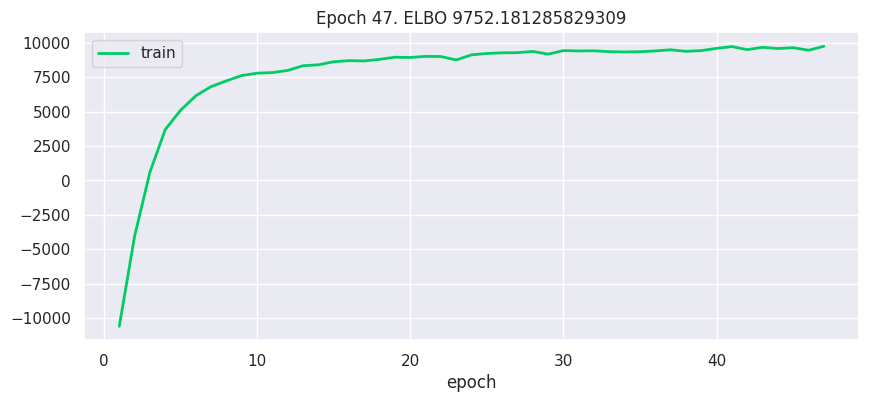

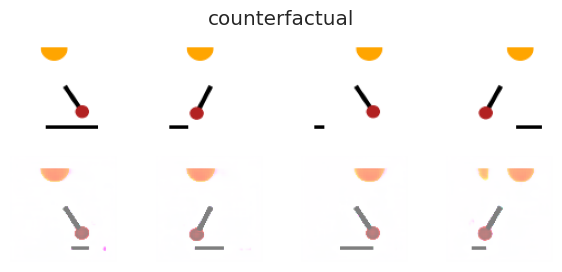

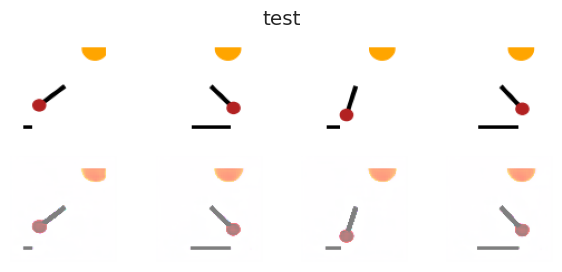

KeyboardInterrupt: 

In [58]:
vae = CVAE(regressor, z_dim=Z_DIM, p=0.1, use_cuda=USE_CUDA)
optimizer = Adam(adam_args)
svi = SVI(vae.model, vae.guide, optimizer, loss=Trace_ELBO())
last_params = {}

train_elbo = []
test_elbo = []
test_epoch_num = []

for epoch in range(300):
    total_epoch_loss_train = run_epoch(svi, Tr_loader, TrCF_loader)
    train_elbo.append(-total_epoch_loss_train)
    test_epoch_num.append(epoch+1)
    if epoch % 1 == 0 :
        torch.save(vae.state_dict(), '/content/drive/MyDrive/thesis/pendulum/anm_06_10_damp01.pth')
        callback(train_elbo, None, test_epoch_num, epoch+1, vae)